<a href="https://colab.research.google.com/github/Dededon/COVID_Twitter/blob/main/gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q tf_geometric
!pip install -q umap-learn
!pip install -q hdbscan

In [ ]:
import os
import sys
sys.path.append('drive/MyDrive/HKUST/Comp 4641 Project')

In [ ]:
import tf_geometric as tfg
import tensorflow as tf
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.utils import shuffle
from collections import defaultdict
from itertools import chain
import random
from node2vec import get_alias_node, get_alias_edge, generate_dfs_second_order_random_walk
import time
from embedding import Embedding

In [ ]:
graph = tfg.Graph(x=np.random.randn(5, 20), edge_index=[[0, 0, 1, 3], [1, 2, 2, 1]])
print(graph)
print(type(graph.x), graph.x)
print(type(graph.edge_index), graph.edge_index)

Graph Shape: x => (5, 20)	edge_index => (2, 4)	y => None
<class 'numpy.ndarray'> [[-0.6054517  -0.43800205  1.1190432   0.04068116 -1.4557985  -0.40195954
   1.1968565   1.0391793  -0.19999991  0.7406687  -0.00756246 -0.7867857
   1.8752297  -0.23555064 -0.28036514 -0.9180866   0.66054046 -0.11250326
  -0.19334614 -0.5354105 ]
 [-0.808298    0.5541919  -0.32236695 -0.28605366 -0.703962   -0.17256828
  -2.2642515   0.19812916 -0.32366922  0.09745684  0.69422054  0.5185028
   1.5437448  -0.92228657 -0.13216089  1.2401592   0.21163127  1.4224763
  -0.41666663 -0.17155567]
 [-2.0567605  -0.00664002  0.2653582   0.1945288  -0.66989505  0.01681617
  -0.70023566  0.28165427  0.02674107 -0.6237229   1.2868816  -1.0326909
  -0.34973937  0.11500733 -0.3056918  -0.5020506  -0.3423136   0.19382189
   0.954952    0.86156994]
 [-0.78810275  0.3257946   1.331855    1.1322508   1.7268549  -0.7853585
  -0.3184239   1.3500602  -1.3758922   1.7275106   0.9616103  -0.88674456
  -0.30857915 -0.812607    0.

# Create Models

In [ ]:
def cosine_embedding_loss(margin=0.0):
    def func(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=y_pred.dtype)
        y_false = tf.constant(1, dtype=y_true.dtype) - y_true
        loss_true = tf.constant(1, dtype=y_pred.dtype) - y_pred
        zero = tf.constant(0, dtype=y_pred.dtype)
        m = tf.constant(margin, dtype=y_pred.dtype)
        loss_false = tf.maximum(zero, y_pred - m)
        return tf.reduce_mean(loss_true * y_true + loss_false * y_false)
    return func

In [ ]:
class GCNModel(tf.keras.Model):

    def __init__(self, edge_index, node_embedding=None, edge_weight=None, emb_size=768, dropout=0.3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_index = edge_index
        if not tf.is_tensor(self.edge_index):
            self.edge_index = tf.convert_to_tensor(edge_index, dtype=tf.int32)
        self.node_embedding = node_embedding
        if self.node_embedding is None:
            self.node_embedding = tf.random.normal((tf.reduce_max(self.edge_index) + 1, emb_size))
        elif not tf.is_tensor(self.node_embedding):
            self.node_embedding = tf.convert_to_tensor(self.node_embedding, dtype=tf.float32)
        self.edge_weight = edge_weight
        if self.edge_weight is None:
            self.edge_weight = tf.ones(self.edge_index.shape[1], dtype=tf.float32)
        elif not tf.is_tensor(self.edge_weight):
            self.edge_weight = tf.convert_to_tensor(self.edge_weight, dtype_hint=tf.float32)
        self.gcn0 = tfg.layers.GCN(emb_size, name="Embedding-1")
        self.dropout0 = tf.keras.layers.Dropout(dropout, name="Dropout-1")
        self.gcn1 = tfg.layers.GCN(emb_size, name="Embedding-2")
        self.dropout1 = tf.keras.layers.Dropout(dropout, name="Dropout-2")
        self.cossim = tf.keras.layers.Dot(-1, True, name="Cossim")

    def __call__(self, inputs, training=None, mask=None, cache=None):
        target_edges = inputs
        h = self.dropout0(self.node_embedding, training=training)
        h = self.gcn0([h, self.edge_index, self.edge_weight], cache=cache)
        h = self.dropout1(h, training=training)
        h = self.gcn1([h, self.edge_index, self.edge_weight], cache=cache)
        h = tf.nn.embedding_lookup(h, target_edges)
        h1 = tf.slice(h, [0, 0, 0], [-1, 1, -1])
        h2 = tf.slice(h, [0, 1, 0], [-1, -1, -1])
        h = self.cossim([h1, h2])
        h = tf.squeeze(h)
        return h

In [ ]:
class GATModel(tf.keras.Model):

    def __init__(self, edge_index, node_embedding=None, edge_weight=None, emb_size=768, dropout=0.3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_index = edge_index
        if not tf.is_tensor(self.edge_index):
            self.edge_index = tf.convert_to_tensor(edge_index, dtype=tf.int32)
        self.node_embedding = node_embedding
        if self.node_embedding is None:
            self.node_embedding = tf.random.normal((tf.reduce_max(self.edge_index) + 1, emb_size))
        elif not tf.is_tensor(self.node_embedding):
            self.node_embedding = tf.convert_to_tensor(self.node_embedding, dtype=tf.float32)
        self.edge_weight = edge_weight
        if self.edge_weight is None:
            self.edge_weight = tf.ones(self.edge_index.shape[1], dtype=tf.int32)
        elif not tf.is_tensor(self.edge_weight):
            self.edge_weight = tf.convert_to_tensor(self.edge_weight, dtype_hint=tf.int32)
        self.gat0 = tfg.layers.GAT(emb_size, 12, name="Embedding-1")
        self.dropout1 = tf.keras.layers.Dropout(dropout, name="Dropout-1")
        self.gat1 = tfg.layers.GAT(emb_size, 12, name="Embedding-2")
        self.dropout2 = tf.keras.layers.Dropout(dropout, name="Dropout-2")
        self.cossim = tf.keras.layers.Dot(-1, True, name="Cossim")

    def call(self, inputs, training=None, mask=None):
        target_edges = inputs
        h = self.dropout1(self.node_embedding, training=training)
        h = self.gat0([h, self.edge_index, self.edge_weight])
        h = self.dropout2(h, training=training)
        h = self.gat1([h, self.edge_index, self.edge_weight])
        h = tf.nn.embedding_lookup(h, target_edges)
        h1 = tf.slice(h, [0, 0, 0], [-1, 1, -1])
        h2 = tf.slice(h, [0, 1, 0], [-1, -1, -1])
        h = self.cossim([h1, h2])
        h = tf.squeeze(h)
        return h

In [ ]:
target_edges = [[0, 1], [1, 2], [0, 3]]
y = [1, 1, 0]

In [ ]:
model = GCNModel(graph.edge_index)
model(target_edges)
model = GCNModel(graph.edge_index, graph.x, graph.edge_weight)
model(target_edges)
model = GCNModel(tf.convert_to_tensor(graph.edge_index), tf.convert_to_tensor(graph.x), tf.convert_to_tensor(graph.edge_weight))
model(target_edges)
model.compile(tf.keras.optimizers.Adam(1e-3), cosine_embedding_loss(0.2))
model.fit(target_edges, y)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/embedding_lookup/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/embedding_lookup/Reshape:0", shape=(None, 768), dtype=float32), dense_shape=Tensor("gradient_tape/embedding_lookup/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/Embedding-2/cond/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/Embedding-2/cond/Identity:0", shape=(None, 768), dtype=float32), dense_shape=Tensor("gradient_tape/Embedding-2/cond/Identity_2:0", shape=(2,), dtype=int32))) to a dense T

1/1 [==============================] - 2s 2s/step - loss: 0.1441


In [ ]:
model = GATModel(graph.edge_index)
model(target_edges)
model = GATModel(graph.edge_index, graph.x, graph.edge_weight)
model(target_edges)
model = GATModel(tf.convert_to_tensor(graph.edge_index), tf.convert_to_tensor(graph.x), tf.convert_to_tensor(graph.edge_weight))
model(target_edges)
model.compile(tf.keras.optimizers.Adam(1e-3), cosine_embedding_loss(0.2))
model.fit(target_edges, y)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gat_model_2/Embedding-2/concat_1/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/gat_model_2/Embedding-2/concat_1/Identity:0", shape=(None, 768), dtype=float32), dense_shape=Tensor("gradient_tape/gat_model_2/Embedding-2/concat_1/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gat_model_2/Embedding-1/concat_1/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/gat_model_2/Embedding-1/concat_1/Identity:0", shape=(None, 768), dtype=float32), dense_shape=Tenso

1/1 [==============================] - 3s 3s/step - loss: 0.1393


# Create graph

In [ ]:
mention_emb = pd.read_csv("pure_mention.csv")
bert_emb = pd.read_csv("drive/MyDrive/HKUST/Comp 4641 Project/BERT_vaccine_result.csv")
graph = nx.readwrite.gexf.read_gexf("drive/MyDrive/HKUST/Comp 4641 Project/networks/retweet_network_vaccine.gexf")
graph = graph.to_undirected()

In [ ]:
nodes = set(mention_emb["node"]).intersection(set(bert_emb["node"])).intersection(set(graph.nodes()))

In [ ]:
bert_emb = bert_emb.loc[bert_emb["node"].isin(nodes)].reset_index()
mention_emb = mention_emb.loc[mention_emb["node"].isin(nodes)].reset_index()
graph = graph.subgraph(nodes)

In [ ]:
nodes = list(graph.nodes)

In [ ]:
#isolated = list(nx.isolates(graph))
#bert_emb = bert_emb.loc[~bert_emb["node"].isin(isolated)].reset_index()
#mention_emb = mention_emb.loc[~mention_emb["node"].isin(isolated)].reset_index()
#graph = nx.Graph(graph)
#graph.remove_nodes_from(isolated)
#nodes.difference_update(set(isolated))

In [ ]:
len(bert_emb), len(mention_emb), graph.number_of_nodes(), len(nodes)

(16195, 16195, 16195, 16195)

In [ ]:
def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    true_edges = set(true_edges)
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        head, tail = np.random.choice(nodes, 2)
        if head != tail and ((head, tail) not in true_edges and (tail, head) not in true_edges) and ((head, tail) not in false_edges and (tail, head) not in false_edges):
            false_edges.add((head, tail))    
    false_edges = sorted(false_edges)
    
    return false_edges

In [ ]:
mention_emb_matrix = [([float(ele) for ele in mention_emb.loc[i]["embedding"][1:-1].split(", ")]) for i in range(len(mention_emb))]
mention_emb["embedding"] = mention_emb_matrix

In [ ]:
emb = list()
for i in range(1, 769):
    emb.append("embedding " + str(i))
list(bert_emb.iloc[0][emb])

[-0.12133824825286865,
 0.05399532616138458,
 0.608423113822937,
 0.02960968017578125,
 0.1871280372142792,
 -0.4464965462684631,
 0.21218664944171906,
 -0.15362975001335144,
 -0.306465208530426,
 -0.010644465684890749,
 0.2231261432170868,
 -0.09063845127820967,
 -0.4078637957572937,
 0.16760745644569394,
 0.24920253455638885,
 -0.2978186309337616,
 0.06643539667129518,
 0.3515656292438507,
 0.2608684301376343,
 0.27510637044906616,
 0.15507695078849792,
 0.1073436439037323,
 0.16081808507442474,
 0.2999546229839325,
 0.2722739279270172,
 0.5185528397560121,
 -0.0010888651013374329,
 -0.24636393785476685,
 -0.0234297513961792,
 0.461880624294281,
 -0.14935213327407834,
 -0.4074425101280213,
 0.2828356325626373,
 0.0011152811348438263,
 0.28848952054977417,
 0.4509463906288147,
 -0.09815798699855804,
 0.0938226580619812,
 0.4136866927146912,
 -0.1802738457918167,
 -0.38076096773147583,
 -0.4009352624416351,
 0.5044963359832764,
 0.3846961557865143,
 0.6146135330200195,
 0.5680739879608

In [ ]:
bert_emb.head()

,index,node,cluster,x,y,embedding 1,embedding 2,embedding 3,embedding 4,embedding 5,embedding 6,embedding 7,embedding 8,embedding 9,embedding 10,embedding 11,embedding 12,embedding 13,embedding 14,embedding 15,embedding 16,embedding 17,embedding 18,embedding 19,embedding 20,embedding 21,embedding 22,embedding 23,embedding 24,embedding 25,embedding 26,embedding 27,embedding 28,embedding 29,embedding 30,embedding 31,embedding 32,embedding 33,embedding 34,embedding 35,...,embedding 729,embedding 730,embedding 731,embedding 732,embedding 733,embedding 734,embedding 735,embedding 736,embedding 737,embedding 738,embedding 739,embedding 740,embedding 741,embedding 742,embedding 743,embedding 744,embedding 745,embedding 746,embedding 747,embedding 748,embedding 749,embedding 750,embedding 751,embedding 752,embedding 753,embedding 754,embedding 755,embedding 756,embedding 757,embedding 758,embedding 759,embedding 760,embedding 761,embedding 762,embedding 763,embedding 764,embedding 765,embedding 766,embedding 767,embedding 768
0,1,0CT0BERSURPRISE,1,13.664807,-8.499029,-0.121338,0.053995,0.608423,0.029610,0.187128,-0.446497,0.212187,-0.153630,-0.306465,-0.010644,0.223126,-0.090638,-0.407864,0.167607,0.249203,-0.297819,0.066435,0.351566,0.260868,0.275106,0.155077,0.107344,0.160818,0.299955,0.272274,0.518553,-0.001089,-0.246364,-0.023430,0.461881,-0.149352,-0.407443,0.282836,0.001115,0.288490,...,0.535485,0.316534,0.371341,-0.736856,-0.081029,0.114843,0.284457,0.235389,-0.726990,-0.066518,0.239916,-0.188375,-0.587729,0.497567,-0.037388,-0.085871,-0.566757,-0.093205,-0.366787,0.696264,-0.307472,0.335420,0.129329,0.228036,0.682674,0.452239,-0.162257,-0.055765,0.080730,0.092065,0.004299,0.393290,-0.116467,-0.244011,-0.164421,-0.304985,-0.040195,0.397153,0.089950,-0.032536
1,2,0Gf1lCKkKy0ucqy,4,11.130979,-17.862398,-0.293506,-0.201247,0.238742,-0.157744,0.170411,-0.530199,0.315560,0.007405,-0.026492,0.080336,0.108603,0.070049,-0.142277,0.009238,0.797891,0.259474,0.289475,0.039171,0.299561,0.386308,-0.442656,-0.049585,0.113164,-0.168908,0.359258,-0.087177,0.208249,-0.501471,0.308025,0.142336,0.211011,0.086209,-0.375515,-0.322300,0.433262,...,0.578213,0.537905,0.125788,0.248425,-0.168486,-0.160350,0.165534,0.611577,-1.103631,0.348976,-0.301460,0.119770,-0.285539,0.142894,-0.113909,0.272813,-0.276348,-0.193594,-0.230061,0.575720,-0.031104,-0.327955,-0.325217,0.377932,0.436479,0.588644,-0.556357,-0.014283,-0.763506,0.011113,0.066450,0.762522,-0.106123,-0.150537,-0.204549,-0.359009,0.231504,0.485965,0.205181,-0.027979
2,13,0noora8,4,11.105285,-17.278978,-0.293506,-0.201247,0.238742,-0.157744,0.170411,-0.530199,0.315560,0.007405,-0.026492,0.080336,0.108603,0.070049,-0.142277,0.009238,0.797891,0.259474,0.289475,0.039171,0.299561,0.386308,-0.442656,-0.049585,0.113164,-0.168908,0.359258,-0.087177,0.208249,-0.501471,0.308025,0.142336,0.211011,0.086209,-0.375515,-0.322300,0.433262,...,0.578213,0.537905,0.125788,0.248425,-0.168486,-0.160350,0.165534,0.611577,-1.103631,0.348976,-0.301460,0.119770,-0.285539,0.142894,-0.113909,0.272813,-0.276348,-0.193594,-0.230061,0.575720,-0.031104,-0.327955,-0.325217,0.377932,0.436479,0.588644,-0.556357,-0.014283,-0.763506,0.011113,0.066450,0.762522,-0.106123,-0.150537,-0.204549,-0.359009,0.231504,0.485965,0.205181,-0.027979
3,17,000stand,0,1.213230,5.153469,0.126828,0.094969,-0.289889,0.299428,0.475988,-0.195353,-0.293491,-0.697884,-0.127930,-0.612434,-0.064261,0.370065,0.277717,-0.186222,0.498363,0.113748,0.364222,-0.187425,0.581699,-0.160406,0.020959,-0.284620,0.143584,-0.070602,0.932336,-0.228586,0.524621,-0.120083,0.159690,-0.114660,-0.232879,-0.624513,-0.045615,-1.084950,-0.084786,...,0.118345,0.259728,0.012495,0.743639,-0.056800,-0.403897,0.362922,0.188703,-0.179404,-0.161997,-0.418444,-0.222885,-0.161729,0.456771,0.075012,0.300921,-0.507777,-0.251069,0.610565,0.083626,0.172967,0.410270,-0.530866,0.312800,0.311509,-0.035222,-0.503706,0.485101,-0.029104,0.002493,0.606663,0.067936,-0.362336,0.033948,-0.209186,0.0170

In [ ]:
emb_matrix = [list(mention_emb[mention_emb["node"] == n]["embedding"])[0] + bert_emb[bert_emb["node"] == n][emb].values.tolist()[0] for n in nodes]

In [ ]:
emb_matrix = np.vstack(emb_matrix)
emb_matrix.shape, emb_matrix.dtype

((16195, 968), dtype('float64'))

In [ ]:
for n in nodes:
    print(n)
    break

RussTidwell


In [ ]:
user_id = dict(zip(nodes, range(len(nodes))))
user_id

{'RussTidwell': 0,
 'acnewsitics': 1,
 'dire_donald': 2,
 'PeterHotez': 3,
 'grassvalleylarr': 4,
 'davokafor': 5,
 'Sani_abdul': 6,
 'MisteralwaysDH': 7,
 'jornalistavitor': 8,
 'Petteri53989165': 9,
 'JoanPennnative': 10,
 'debilu2': 11,
 'Deletmen': 12,
 'CoronaUpdateBot': 13,
 'viralvideovlogs': 14,
 'atla_fan': 15,
 'Teram323Tere': 16,
 'MattMurph24': 17,
 'missb62': 18,
 'lowellbellew': 19,
 'tedlieu': 20,
 'ErinaK19': 21,
 'GIFFCloud': 22,
 'RexannaKeats': 23,
 'rnklssn': 24,
 'heyjudymodesta': 25,
 'Mjames21Pete': 26,
 'PartyphonesThe': 27,
 'pescara121': 28,
 'y_kitman': 29,
 'rigboss': 30,
 'viriyabot': 31,
 '86GOPFascism': 32,
 'ana_scmum': 33,
 'PonytaEle': 34,
 'vmrwanda': 35,
 'viccan1': 36,
 'GiannaJax': 37,
 'GameHea58461068': 38,
 '92ZId3wUSDVueke': 39,
 'nanmac321': 40,
 'janzentina': 41,
 'nohope2017': 42,
 'JenniferRidgway': 43,
 'SkyNews': 44,
 'DarkKnight0907': 45,
 'AngelaBodden56': 46,
 '_LizToday': 47,
 'Ronilj261': 48,
 'projectrem': 49,
 'ramboisinjured': 50,

In [ ]:
def get_random_walk_edge():
    st = time.time()
    np.random.seed(0)
    p=5
    q=1
    num_walks = 7
    walk_length = 10
    nodes = list(graph.nodes())
    walks = set()
    # generate alias nodes
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)
    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)
        alias_edges[(edge[1], edge[0])] = get_alias_edge(graph, edge[1], edge[0], p=p, q=q)
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walk = generate_dfs_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node
            )
            walks.update({(user_id[node], user_id[n]) for n in walks if n != node})
    return list(walks)

In [ ]:
false_edges = generate_false_edges(graph.edges, graph.number_of_edges())

In [ ]:
graph.number_of_nodes(), len(user_id)

(16195, 16195)

In [ ]:
edge_index = list()
for edge in graph.edges:
    edge_index.append(
        np.array([[user_id[edge[0]]], [user_id[edge[1]]]])
    )
edge_index = np.hstack(edge_index)
edge_index.shape

(2, 2142)

In [ ]:
false_edge_index = list()
for edge in false_edges:
    false_edge_index.append(
        np.array([user_id[edge[0]], user_id[edge[1]]])
    )
false_edge_index = np.vstack(false_edge_index)
false_edge_index.shape

(2142, 2)

In [ ]:
edges = np.concatenate((np.transpose(edge_index), false_edge_index))
Y = np.concatenate((np.ones(edge_index.shape[1]), np.zeros(edge_index.shape[1])))
edges.shape, Y.shape

((4284, 2), (4284,))

In [ ]:
edges, Y = shuffle(edges, Y)
edges.shape, Y.shape

((4284, 2), (4284,))

In [ ]:
g = tfg.Graph(emb_matrix, edge_index)
g = g.convert_edge_to_directed()
g.edge_index.shape

(2, 4270)

In [ ]:
score = list()
for i in range(int(Y.shape[0]/128 + 1)):
    h = tf.nn.embedding_lookup(g.x, edges[i * 128: (i + 1) * 128])
    h1 = tf.slice(h, [0, 0, 0], [-1, 1, -1])
    h2 = tf.slice(h, [0, 1, 0], [-1, -1, -1])
    h = tf.keras.layers.Dot(-1, True, name="Cossim")([h1, h2])
    h = tf.squeeze(h)
    score.append(cosine_embedding_loss()(Y[i * 128: (i + 1) * 128], h))
np.mean(score)

0.44035506

In [ ]:
model = GATModel(g.edge_index, g.x, emb_size=256)
model.compile(tf.keras.optimizers.Adam(1e-3), cosine_embedding_loss())
model.fit(edges, Y, batch_size=128, epochs=14, validation_split=0.3)

Epoch 1/14


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gat_model_3/Embedding-2/concat_1/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/gat_model_3/Embedding-2/concat_1/Identity:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/gat_model_3/Embedding-2/concat_1/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gat_model_3/Embedding-1/concat_1/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/gat_model_3/Embedding-1/concat_1/Identity:0", shape=(None, 256), dtype=float32), dense_shape=Tenso

24/24 [==============================] - 4s 65ms/step - loss: 0.1915 - val_loss: 0.1309
Epoch 2/14
24/24 [==============================] - 1s 43ms/step - loss: 0.1342 - val_loss: 0.1252
Epoch 3/14
24/24 [==============================] - 1s 42ms/step - loss: 0.1258 - val_loss: 0.1235
Epoch 4/14
24/24 [==============================] - 1s 43ms/step - loss: 0.1210 - val_loss: 0.1232
Epoch 5/14
24/24 [==============================] - 1s 43ms/step - loss: 0.1183 - val_loss: 0.1216
Epoch 6/14
24/24 [==============================] - 1s 44ms/step - loss: 0.1166 - val_loss: 0.1226
Epoch 7/14
24/24 [==============================] - 1s 43ms/step - loss: 0.1152 - val_loss: 0.1215
Epoch 8/14
24/24 [==============================] - 1s 43ms/step - loss: 0.1118 - val_loss: 0.1199
Epoch 9/14
24/24 [==============================] - 1s 43ms/step - loss: 0.1115 - val_loss: 0.1208
Epoch 10/14
24/24 [==============================] - 1s 43ms/step - loss: 0.1108 - val_loss: 0.1227
Epoch 11/14
24/24 [=

In [ ]:
model1 = GCNModel(g.edge_index, g.x, emb_size=256)
model1.compile(tf.keras.optimizers.Adam(5e-4), cosine_embedding_loss())
model1.fit(edges, Y, batch_size=128, epochs=18, validation_split=0.3)

Epoch 1/18


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/embedding_lookup/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/embedding_lookup/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/embedding_lookup/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/Embedding-2/cond/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/Embedding-2/cond/Identity:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/Embedding-2/cond/Identity_2:0", shape=(2,), dtype=int32))) to a dense T

24/24 [==============================] - 3s 55ms/step - loss: 0.2027 - val_loss: 0.1323
Epoch 2/18
24/24 [==============================] - 1s 40ms/step - loss: 0.1447 - val_loss: 0.1226
Epoch 3/18
24/24 [==============================] - 1s 39ms/step - loss: 0.1332 - val_loss: 0.1214
Epoch 4/18
24/24 [==============================] - 1s 39ms/step - loss: 0.1294 - val_loss: 0.1193
Epoch 5/18
24/24 [==============================] - 1s 39ms/step - loss: 0.1258 - val_loss: 0.1204
Epoch 6/18
24/24 [==============================] - 1s 39ms/step - loss: 0.1227 - val_loss: 0.1196
Epoch 7/18
24/24 [==============================] - 1s 39ms/step - loss: 0.1205 - val_loss: 0.1192
Epoch 8/18
24/24 [==============================] - 1s 39ms/step - loss: 0.1189 - val_loss: 0.1203
Epoch 9/18
24/24 [==============================] - 1s 38ms/step - loss: 0.1179 - val_loss: 0.1200
Epoch 10/18
24/24 [==============================] - 1s 38ms/step - loss: 0.1161 - val_loss: 0.1172
Epoch 11/18
24/24 [=

In [ ]:
class ModifiedGATModel(tf.keras.Model):

    def __init__(self, edge_index, node_embedding=None, edge_weight=None, emb_size=768, dropout=0.3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_index = edge_index
        if not tf.is_tensor(self.edge_index):
            self.edge_index = tf.convert_to_tensor(edge_index, dtype=tf.int32)
        self.node_embedding = node_embedding
        if self.node_embedding is None:
            self.node_embedding = tf.random.normal((tf.reduce_max(self.edge_index) + 1, emb_size))
        elif not tf.is_tensor(self.node_embedding):
            self.node_embedding = tf.convert_to_tensor(self.node_embedding, dtype=tf.float32)
        self.edge_weight = edge_weight
        if self.edge_weight is None:
            self.edge_weight = tf.ones(self.edge_index.shape[1], dtype=tf.int32)
        elif not tf.is_tensor(self.edge_weight):
            self.edge_weight = tf.convert_to_tensor(self.edge_weight, dtype_hint=tf.int32)
        self.gat0 = tfg.layers.GAT(emb_size, 12, name="Embedding-1")
        self.dropout1 = tf.keras.layers.Dropout(dropout, name="Dropout-1")
        self.gat1 = tfg.layers.GAT(emb_size, 12, name="Embedding-2")
        self.dropout2 = tf.keras.layers.Dropout(dropout, name="Dropout-2")

    def call(self, inputs, training=None, mask=None):
        target_edges = inputs
        h = self.dropout1(self.node_embedding, training=training)
        h = self.gat0([h, self.edge_index, self.edge_weight])
        h = self.dropout2(h, training=training)
        h = self.gat1([h, self.edge_index, self.edge_weight])
        return h

In [ ]:
class ModifiedGCNModel(tf.keras.Model):

    def __init__(self, edge_index, node_embedding=None, edge_weight=None, emb_size=768, dropout=0.3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_index = edge_index
        if not tf.is_tensor(self.edge_index):
            self.edge_index = tf.convert_to_tensor(edge_index, dtype=tf.int32)
        self.node_embedding = node_embedding
        if self.node_embedding is None:
            self.node_embedding = tf.random.normal((tf.reduce_max(self.edge_index) + 1, emb_size))
        elif not tf.is_tensor(self.node_embedding):
            self.node_embedding = tf.convert_to_tensor(self.node_embedding, dtype=tf.float32)
        self.edge_weight = edge_weight
        if self.edge_weight is None:
            self.edge_weight = tf.ones(self.edge_index.shape[1], dtype=tf.float32)
        elif not tf.is_tensor(self.edge_weight):
            self.edge_weight = tf.convert_to_tensor(self.edge_weight, dtype_hint=tf.float32)
        self.gcn0 = tfg.layers.GCN(emb_size, name="Embedding-1")
        self.dropout0 = tf.keras.layers.Dropout(dropout, name="Dropout-1")
        self.gcn1 = tfg.layers.GCN(emb_size, name="Embedding-2")
        self.dropout1 = tf.keras.layers.Dropout(dropout, name="Dropout-2")

    def __call__(self, inputs, training=None, mask=None, cache=None):
        target_edges = inputs
        h = self.dropout0(self.node_embedding, training=training)
        h = self.gcn0([h, self.edge_index, self.edge_weight], cache=cache)
        h = self.dropout1(h, training=training)
        h = self.gcn1([h, self.edge_index, self.edge_weight], cache=cache)
        return h

In [ ]:
model.node_embedding

<tf.Tensor: shape=(16195, 968), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        , ...,  0.42469802,
         0.1374114 , -0.13913251],
       [ 0.        ,  0.        ,  1.        , ...,  0.39715323,
         0.08995034, -0.03253558],
       [ 1.        ,  1.        ,  0.        , ...,  0.599097  ,
         0.02087672, -0.01890823],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  0.24843803,
        -0.22389786, -0.3854317 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.64226437,
        -0.13686202,  0.43796372],
       [ 0.        ,  0.        ,  0.        , ...,  0.64226437,
        -0.13686202,  0.43796372]], dtype=float32)>

In [ ]:
modifiedGAT = ModifiedGATModel(model.edge_index, model.node_embedding, model.edge_weight, emb_size=256)
modifiedGAT(np.array([[6, 11]]))
modifiedGCN = ModifiedGCNModel(model1.edge_index, model1.node_embedding, model1.edge_weight, emb_size=256)
modifiedGCN(np.array([[6, 11]]))

<tf.Tensor: shape=(16195, 256), dtype=float32, numpy=
array([[ 0.2557102 , -0.17383067, -0.26007277, ...,  0.4611179 ,
        -0.07767147, -0.25674137],
       [-0.03440616,  0.38867268, -0.42903927, ...,  0.46709996,
        -0.30132255,  0.00152212],
       [ 0.35769805, -0.2071952 , -0.2053929 , ...,  0.52137035,
        -0.28539407, -0.01635909],
       ...,
       [ 0.12411886, -0.10728224, -0.24789378, ...,  0.3719284 ,
        -0.4373202 , -0.18788594],
       [-0.2277208 , -0.01841882, -0.26114002, ...,  0.49931833,
        -0.26628956, -0.10556044],
       [-0.2277208 , -0.01841882, -0.26114002, ...,  0.49931833,
        -0.26628956, -0.10556044]], dtype=float32)>

In [ ]:
modifiedGAT.set_weights(model.get_weights())
modifiedGCN.set_weights(model1.get_weights())

In [ ]:
gatembbed = modifiedGAT(g.x)
gcnembbed = modifiedGCN(g.x)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


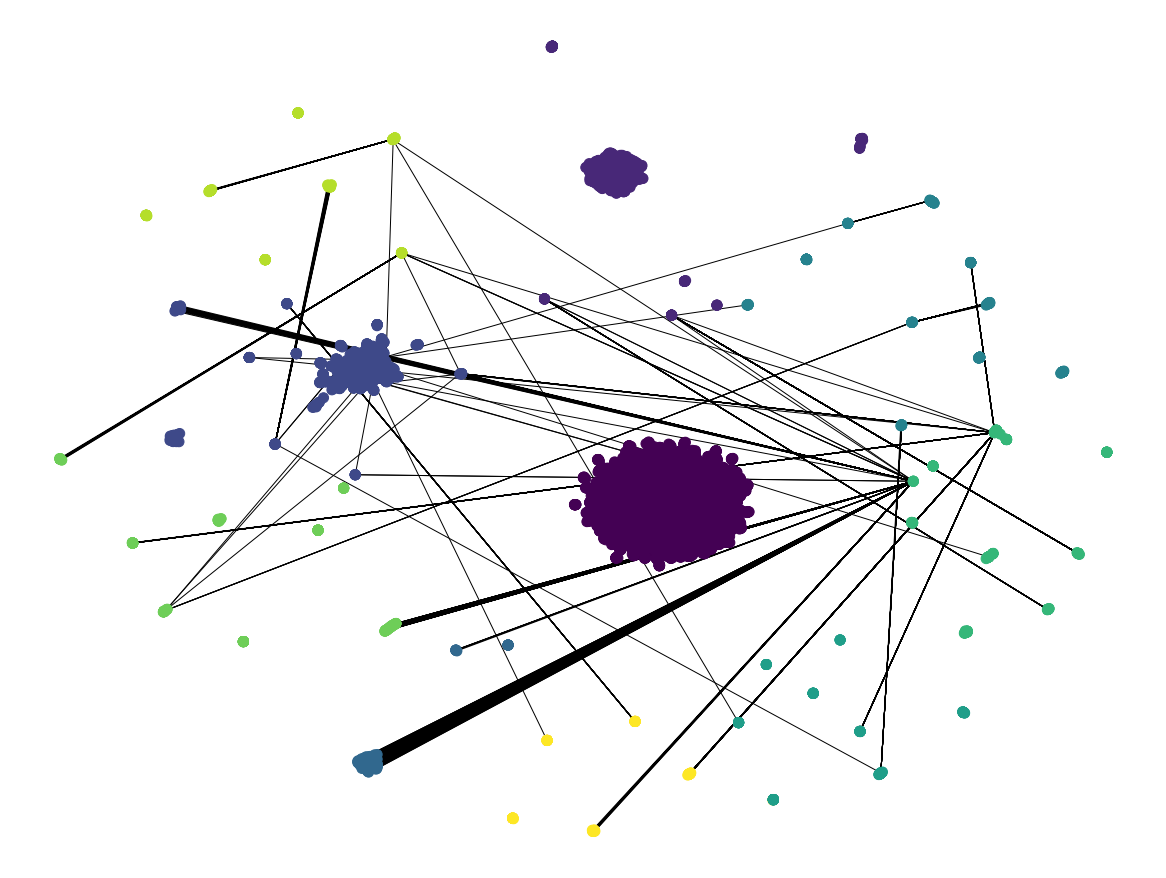

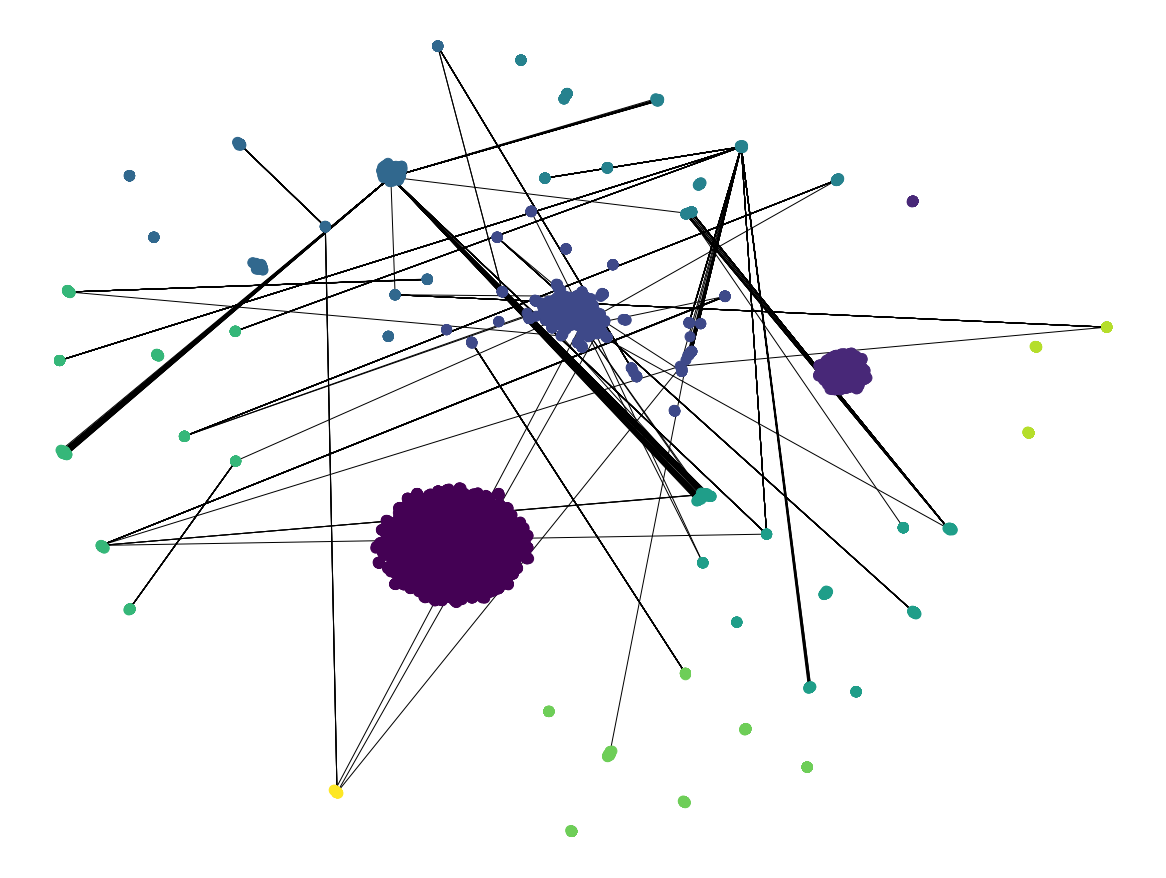

In [ ]:
gatemb = Embedding(dict(zip(user_id.keys(), gatembbed.numpy())))
gatemb.dimReduce()
gatemb.cluster()
gatemb.plot(graph)
gcnemb = Embedding(dict(zip(user_id.keys(), gcnembbed.numpy())))
gcnemb.dimReduce()
gcnemb.cluster()
gcnemb.plot(graph)

In [ ]:
import csv

f = open('drive/MyDrive/HKUST/Comp 4641 Project/mentionBERT_vaccine_retweet_gat_result.csv', 'w')

emb_dim = list()
for i in range(256):
    emb_dim.append('embedding ' + str(i + 1))

nodes_cluster = gatemb.nodes_cluster
nodes_pos = gatemb.nodes_pos
embedding = gatemb.embedding

writer = csv.writer(f)
writer.writerow(['node', 'cluster', 'x', 'y'] + emb_dim)
for key in nodes_cluster.keys():
    wlist = [key, nodes_cluster[key]] + nodes_pos[key].tolist() + embedding[key].tolist()
    writer.writerow(wlist)

f.close()

In [ ]:
import csv

f = open('drive/MyDrive/HKUST/Comp 4641 Project/mentionBERT_vaccine_retweet_gcn_result.csv', 'w')

emb_dim = list()
for i in range(256):
    emb_dim.append('embedding ' + str(i + 1))

nodes_cluster = gcnemb.nodes_cluster
nodes_pos = gcnemb.nodes_pos
embedding = gcnemb.embedding

writer = csv.writer(f)
writer.writerow(['node', 'cluster', 'x', 'y'] + emb_dim)
for key in nodes_cluster.keys():
    wlist = [key, nodes_cluster[key]] + nodes_pos[key].tolist() + embedding[key].tolist()
    writer.writerow(wlist)

f.close()

In [ ]:
graph.number_of_nodes(), len(gatemb.nodes_cluster)

(2715, 2715)

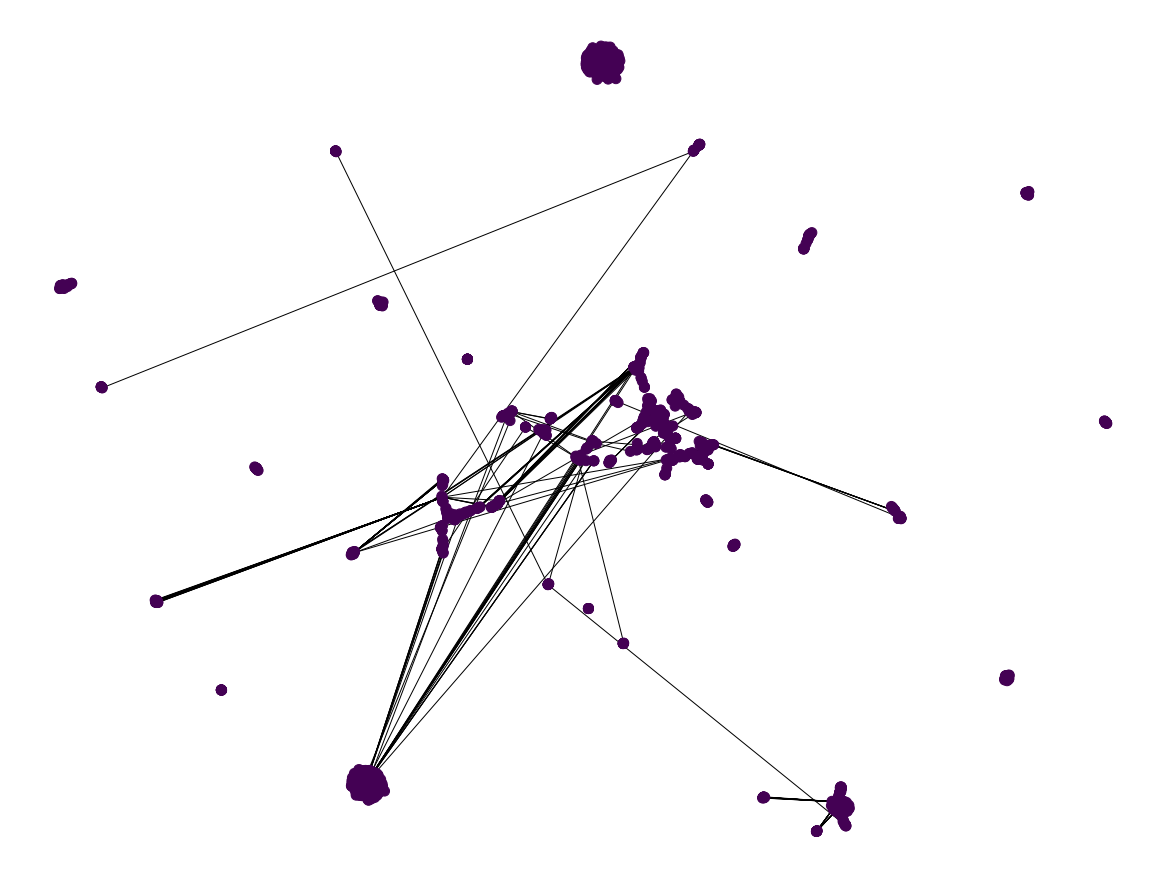

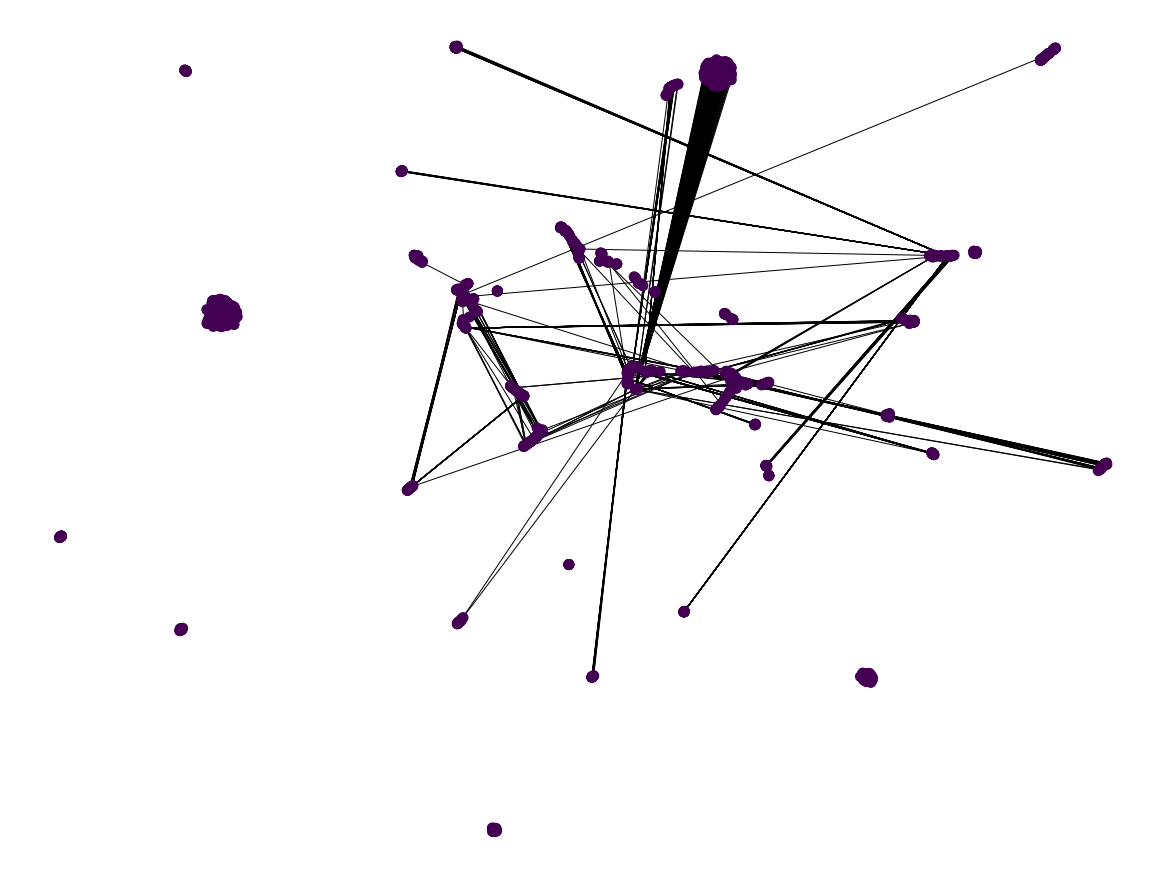

In [ ]:
gatemb.plot(graph)
gcnemb.plot(graph)